In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import statsmodels.formula.api as smf
import math
import statsmodels.formula.api as sm

In [246]:
data = pd.read_csv('data.csv', sep=';')

## Data quality check / cleaning / preparation 

### Data quality check
*By Yide Cui*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [247]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [248]:
data.y.value_counts()

no     3668
yes     451
Name: y, dtype: int64

Text(0.5, 1.0, 'Has the client subscribed a term deposit?')

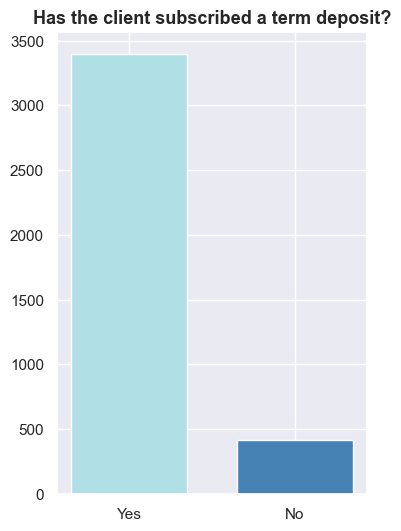

In [249]:
Subscription = {'Yes':3398, 'No':413}
YN = list(Subscription.keys())
Counts = list(Subscription.values())
  
fig = plt.figure(figsize = (4, 6))

# creating the bar plot
plt.bar(YN, Counts, color = ['powderblue', 'steelblue'], width = 0.7)
 
plt.title("Has the client subscribed a term deposit?",fontdict={'fontsize': '13', 'fontweight' : 'bold'})

### Data cleaning
*By Yide Cui*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [250]:
data['education']=data['education'].replace('unknown',np.NaN)
data['marital']=data['marital'].replace('unknown',np.NaN)
data['housing']=data['housing'].replace('unknown',np.NaN)
data['loan']=data['loan'].replace('unknown',np.NaN)
data['job']=data['job'].replace('unknown',np.NaN)

data.drop(['default'], axis=1, inplace = True)
data.dropna(axis=0, inplace=True)

### Data preparation
*By Yide Cui and Angelica Wang*


In [251]:
## Binning the catogorical Data
data['education'] = data['education'].apply(lambda x:'Primary' if 'basic' in x else 'Primary' if 'illiterate' in x else 'Secondary' if 'high.school' in x else 'Secondary' if 'professional.course' in x else 'Tertiary' if 'university.degree' in x else x)
data['job'] = data['job'].apply(lambda x:'Employed' if 'admin.' in x else 'Employed' if 'blue-collar' in x else 'Employed' if 'technician' in x else 'Employed' if 'services' in x else 'Employed' if 'management' in x else 'Employed' if 'self-employed' in x else 'Employed' if 'entrepreneur' in x else 'Unemployed' if 'retired' in x else 'Unemployed' if 'unemployed' in x else 'Unemployed' if 'housemaid' in x else 'Unemployed' if 'student' in x else x)
data['marital'] = data['marital'].apply(lambda x:'single' if 'divorce' in x else x)
data['poutcome_modified'] = data['poutcome'].apply(lambda x:'failure' if 'nonexistent' in x else x)

In [252]:
data['y_dum']= data['y'].map({'no': 0, 'yes': 1})

In [253]:
data.drop(['y'], axis=1, inplace = True)

In [254]:
data['poutcome_success'] = data['poutcome'].map({'failure': 0, 'success': 1})

In [255]:
## Rename the column
data = data.rename(columns={'emp.var.rate': 'emp_var_rate', 'cons.price.idx': 'cons_price_idx', 'cons.conf.idx': 'cons_conf_idx', 'nr.employed': 'nr_employed'})

In [256]:
# Creating training and testing datasets
np.random.seed(2)
train = data.sample(round(data.shape[0]*0.8))
test = data.drop(train.index)

In [257]:
train.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum,poutcome_success
398,45,Employed,single,Tertiary,no,yes,cellular,may,fri,133,...,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,failure,0,NaN
526,38,Employed,married,Tertiary,no,no,telephone,may,tue,477,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,failure,0,NaN
3707,60,Unemployed,married,Secondary,no,no,cellular,may,thu,181,...,1,success,-1.8,93.876,-40.0,0.699,5008.7,success,1,1.0
3687,30,Employed,single,Tertiary,no,no,cellular,sep,thu,327,...,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,failure,1,NaN
618,31,Employed,married,Tertiary,no,no,telephone,may,wed,197,...,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,failure,0,NaN


In [258]:
test.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum,poutcome_success
6,32,Employed,single,Tertiary,yes,no,cellular,sep,mon,290,...,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,failure,0,NaN
10,25,Employed,single,Primary,yes,no,cellular,jul,thu,301,...,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,failure,0,NaN
20,55,Employed,married,Primary,yes,no,cellular,jul,tue,326,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,failure,0,NaN
25,38,Employed,married,Secondary,yes,no,cellular,aug,mon,479,...,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,failure,1,NaN
26,36,Employed,single,Secondary,no,no,telephone,may,wed,446,...,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,failure,0,NaN


### Resampling Data through SMOTE
*By Yide Cui*

In [259]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTENC

Text(0.5, 1.0, 'Has the client subscribed a term deposit?')

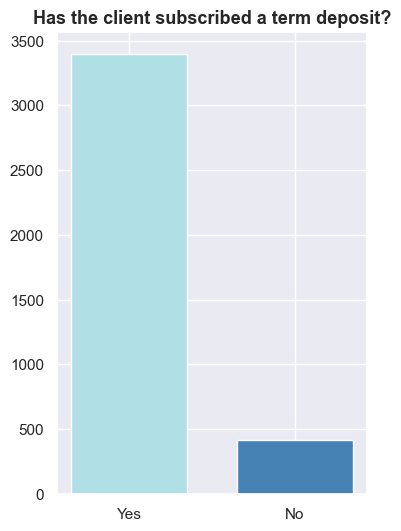

In [260]:
Subscription = {'Yes':3398, 'No':413}
YN = list(Subscription.keys())
Counts = list(Subscription.values())
  
fig = plt.figure(figsize = (4, 6))

# creating the bar plot
plt.bar(YN, Counts, color = ['powderblue', 'steelblue'], width = 0.7)
 
plt.title("Has the client subscribed a term deposit?",fontdict={'fontsize': '13', 'fontweight' : 'bold'})

In [261]:
data.drop(['poutcome_success'], axis=1, inplace = True)

In [264]:
X=data.iloc[:,:20]
y=data.iloc[:,20]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [265]:
## Balancing the train data
sm_nc = SMOTENC(categorical_features=[1,2,3,4,5,6,7,8,13,19], random_state=20)
X_train_res, y_train_res = sm_nc.fit_resample(X_train, y_train)

Y = pd.DataFrame(y_train_res, columns=["y_dum"])
train = pd.concat([X_train_res, Y], axis = 1) 
train = train.reindex(columns=["age", "job", "marital", "education", "housing", "loan", "contact", "month", 'day_of_week', "duration", "campaign", "pdays", "previous", "poutcome", "emp_var_rate", "cons_price_idx", "cons_conf_idx","euribor3m", "nr_employed", "poutcome_modified", "y_dum"])
train.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum
0,32,Unemployed,single,Tertiary,no,no,telephone,may,fri,21,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,failure,0
1,51,Employed,married,Secondary,yes,no,telephone,jun,mon,81,...,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,failure,0
2,31,Unemployed,single,Tertiary,yes,no,cellular,jul,tue,309,...,6,3,success,-1.7,94.215,-40.3,0.835,4991.6,success,1
3,26,Employed,married,Primary,yes,no,telephone,jun,wed,71,...,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,failure,0
4,31,Employed,single,Primary,no,no,cellular,jul,wed,1432,...,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,failure,0


## Exploratory data analysis

### Check VIF
*by Yide Cui*

In [266]:
train_dummies=pd.get_dummies(train.iloc[:,0:])

In [267]:
X = train_dummies[['age', 'duration','campaign','pdays','previous', 'euribor3m', 'cons_price_idx','cons_conf_idx', 'nr_employed','job_Employed', 'marital_married', 'education_Primary', 'housing_no', 'loan_no', 'contact_cellular', 'month_mar', 'poutcome_failure', 'day_of_week_fri']]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["y_dum"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                y_dum            VIF
0               const  500895.557183
1                 age       1.134226
2            duration       1.095076
3            campaign       1.078082
4               pdays       3.169159
5            previous       3.410182
6           euribor3m      54.519393
7      cons_price_idx       6.316540
8       cons_conf_idx       2.486192
9         nr_employed      43.048385
10       job_Employed       1.083310
11    marital_married       1.111546
12  education_Primary       1.128299
13         housing_no       1.038936
14            loan_no       1.039213
15   contact_cellular       1.528487
16          month_mar       1.055487
17   poutcome_failure       1.589731
18    day_of_week_fri       1.016063


In [268]:
## Deleting 'nr_employed'
X = train_dummies[['age', 'duration','campaign','pdays','previous', 'euribor3m', 'cons_price_idx','cons_conf_idx', 'job_Employed', 'marital_married', 'education_Primary', 'housing_no', 'loan_no', 'contact_cellular', 'month_mar', 'poutcome_failure', 'day_of_week_fri']]

X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["y_dum"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                y_dum           VIF
0               const  43823.280866
1                 age      1.134193
2            duration      1.095055
3            campaign      1.067685
4               pdays      3.158839
5            previous      3.409901
6           euribor3m      2.312153
7      cons_price_idx      1.932987
8       cons_conf_idx      1.263592
9        job_Employed      1.082362
10    marital_married      1.107534
11  education_Primary      1.126969
12         housing_no      1.038088
13            loan_no      1.039197
14   contact_cellular      1.519433
15          month_mar      1.055477
16   poutcome_failure      1.587974
17    day_of_week_fri      1.013985


### Heatmap
*by Angelica Wang*

<AxesSubplot:>

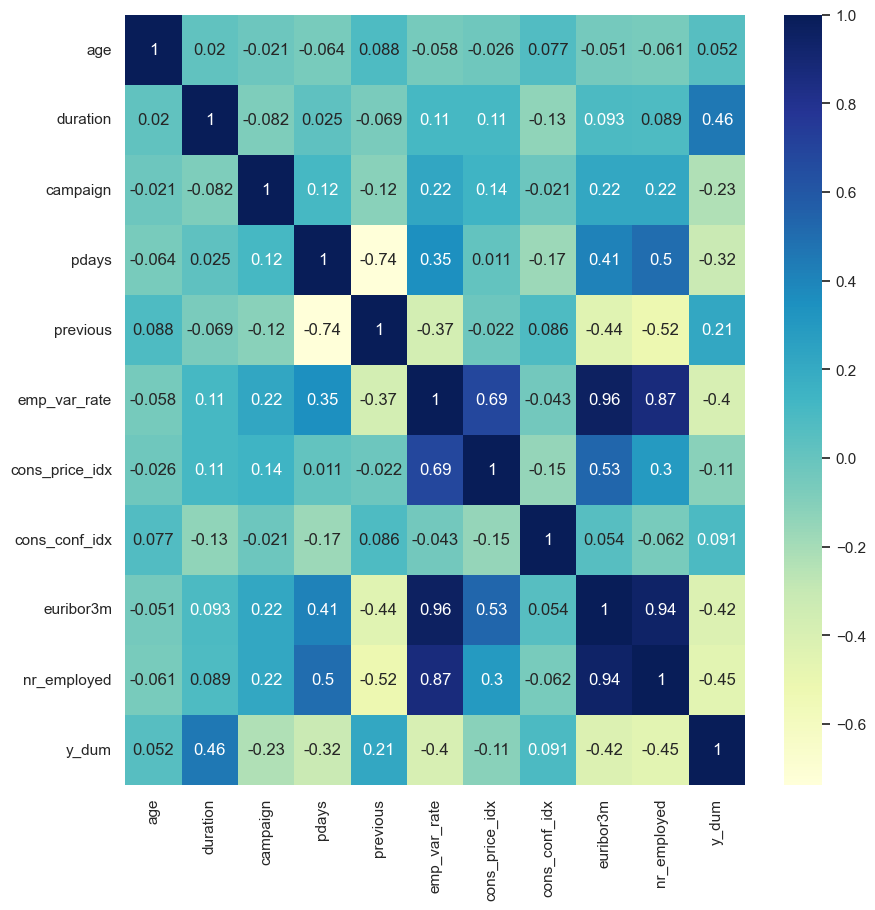

In [269]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)

### Visualizations with Individual Predictors
*By Angelica Wang*
#### Visualizations for Numerical Predictors

[Text(0.5, 0, 'euribor3m_idx'), Text(0, 0.5, 'subscription_rate')]

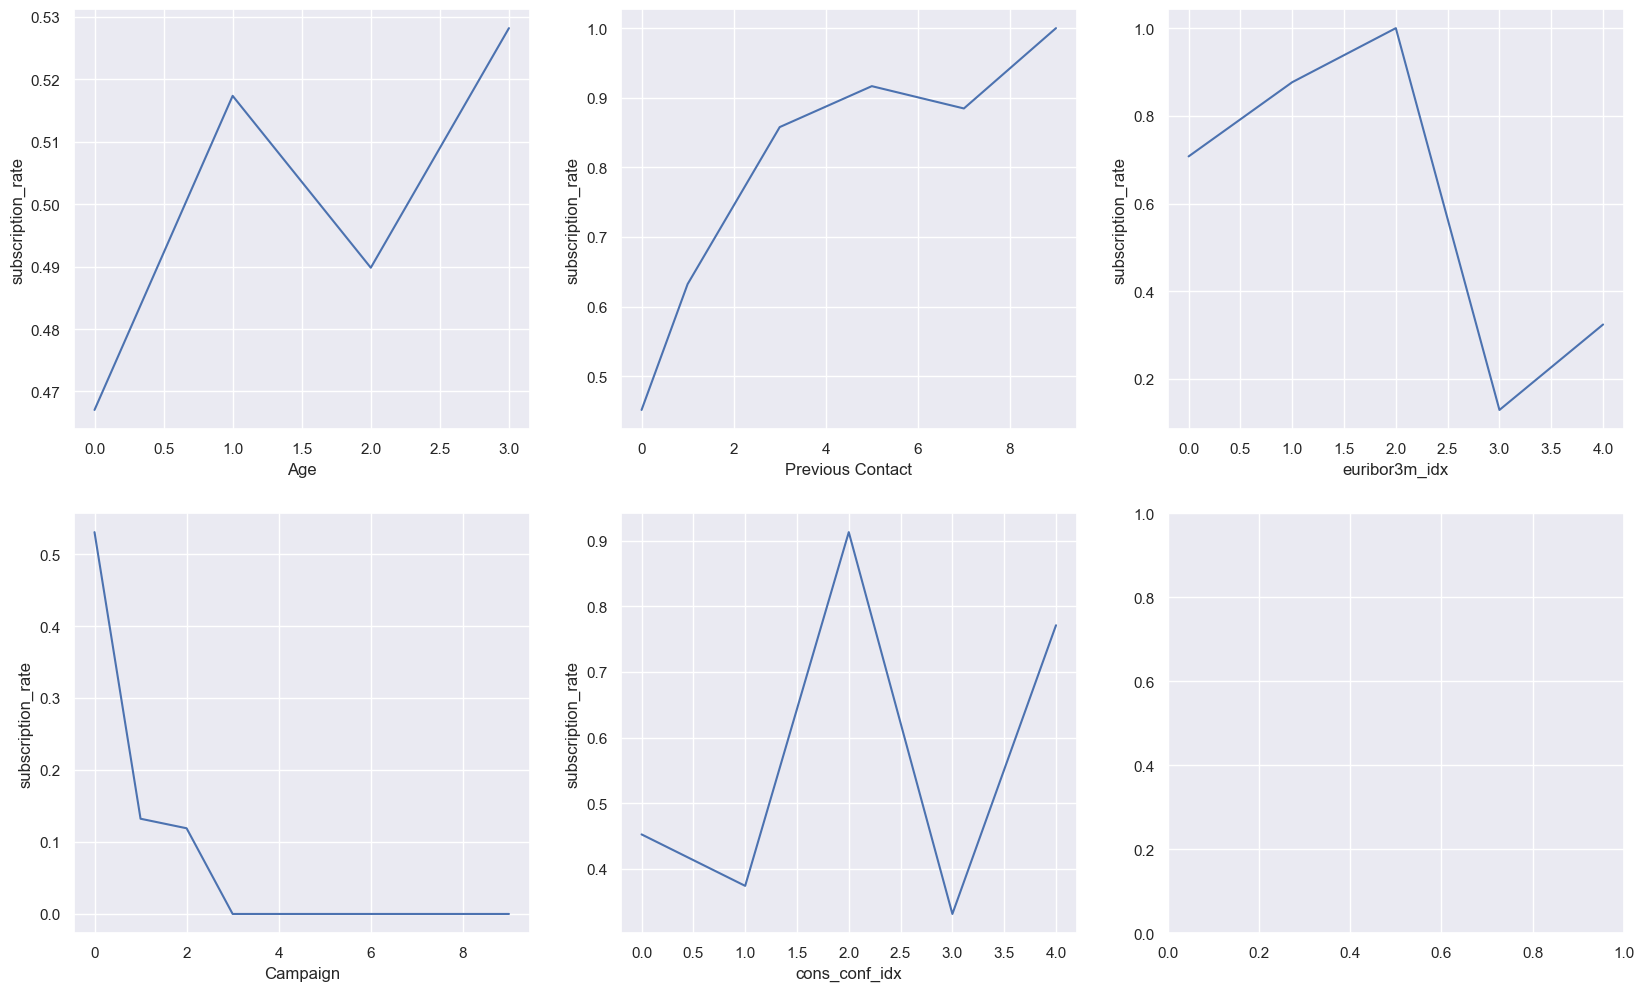

In [270]:
sns.set(rc={'figure.figsize':(20,12)})
fig, axes = plt.subplots(nrows=2, ncols=3)
#Plotting individual subplots

#Binning Age
binned_age = pd.qcut(train['age'],4,retbins=True)
train['age_binned'] = binned_age[0]
age_data = train.groupby('age_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Age Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_age = sns.lineplot(x = age_data.index, y= age_data['subscription_rate'], ax=axes[0,0])
ax_age.set(xlabel='Age', ylabel='subscription_rate')

#Binning number of previous contacts
binned_previous = pd.cut(train['previous'],10, retbins=True, duplicates='drop')
train['previous_binned'] = binned_previous[0]
previous_data = train.groupby('previous_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Previous Contact Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_previous = sns.lineplot(x = previous_data.index, y= previous_data['subscription_rate'], ax = axes[0,1])
ax_previous.set(xlabel='Previous Contact', ylabel='subscription_rate')


#Binning number of Campaign
binned_campaign = pd.cut(train['campaign'],10, retbins=True, duplicates='drop')
train['campaign_binned'] = binned_campaign[0]
campaign_data = train.groupby('campaign_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Previous Contact Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_campaign = sns.lineplot(x = campaign_data.index, y= campaign_data['subscription_rate'], ax = axes[1,0])
ax_campaign.set(xlabel='Campaign', ylabel='subscription_rate')

#Binning number of Campaign
binned_cons_conf_idx = pd.cut(train['cons_conf_idx'],5, retbins=True, duplicates='drop')
train['cons_conf_idx_binned'] = binned_cons_conf_idx[0]
cons_conf_idx_data = train.groupby('cons_conf_idx_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Previous Contact Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_cons_conf_idx = sns.lineplot(x = cons_conf_idx_data.index, y= cons_conf_idx_data['subscription_rate'], ax = axes[1,1])
ax_cons_conf_idx.set(xlabel='cons_conf_idx', ylabel='subscription_rate')

#Binning euribor 3 month rate
binned_euribor3m = pd.cut(train['euribor3m'],5, retbins=True, duplicates='drop')
train['euribor3m_binned'] = binned_euribor3m[0]
euribor3m_data = train.groupby('euribor3m_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Previous Contact Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_euribor3m = sns.lineplot(x = euribor3m_data.index, y= euribor3m_data['subscription_rate'], ax = axes[0,2])
ax_euribor3m.set(xlabel='euribor3m_idx', ylabel='subscription_rate')



#### Visualization for Categorical Variables
*by Angelica Wang*

[Text(0.5, 0, 'housing'), Text(0, 0.5, 'subscription_rate')]

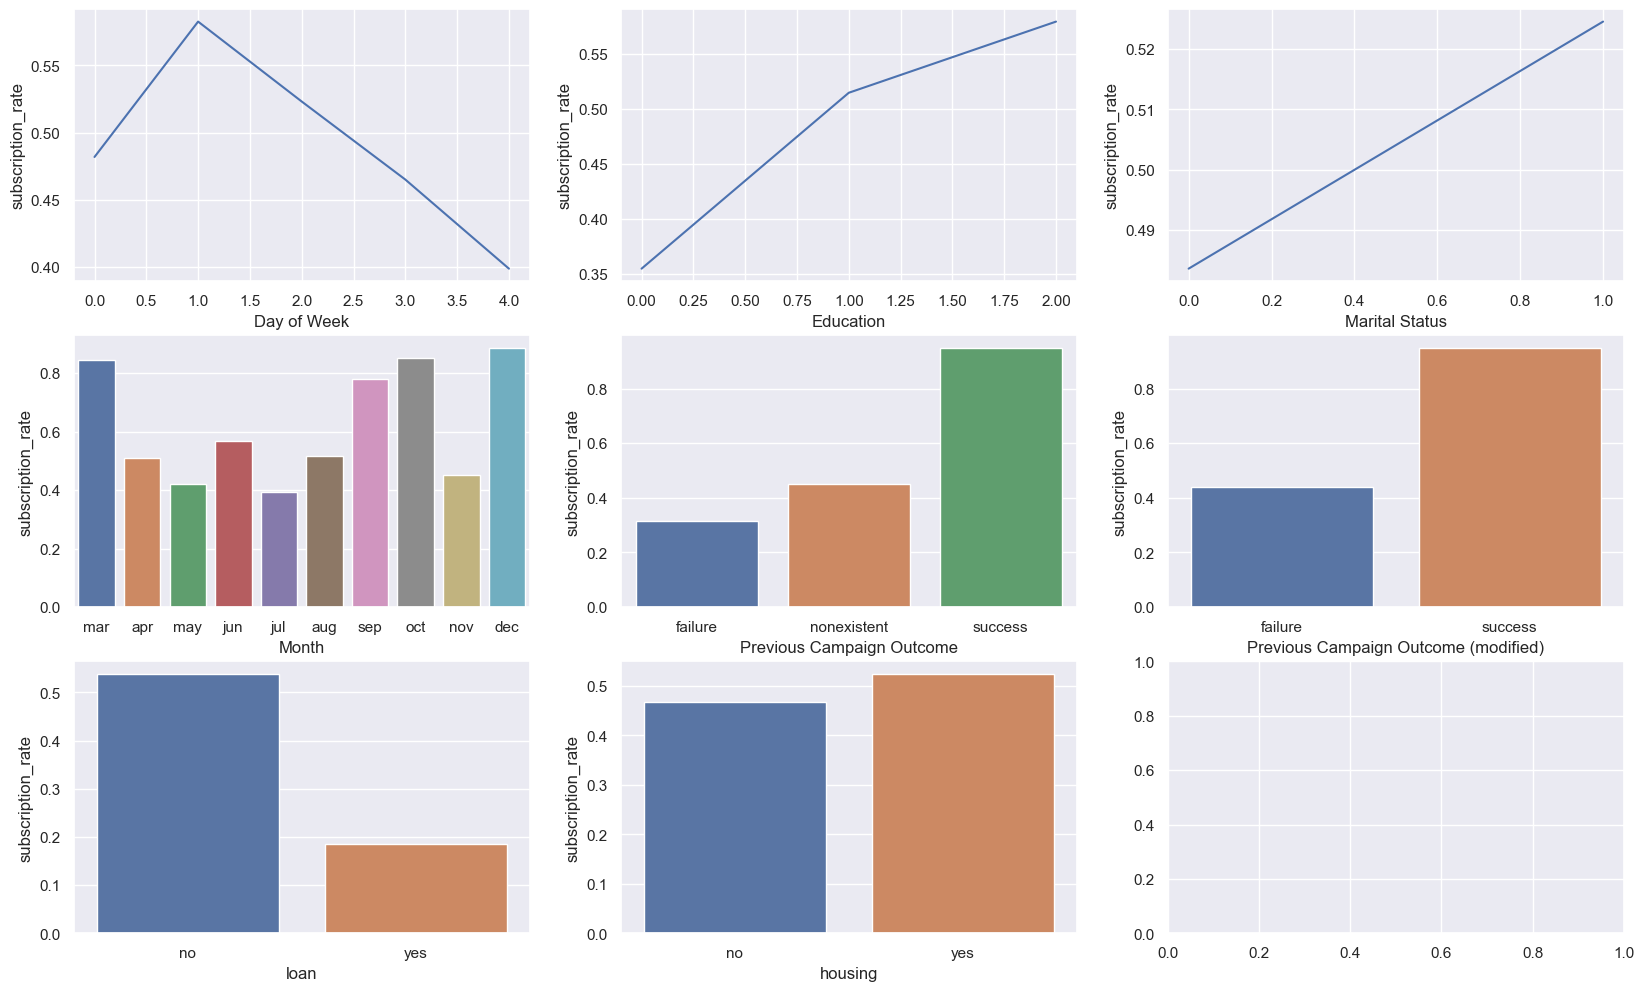

In [271]:
sns.set(rc={'figure.figsize':(20,12)})
fig, axes = plt.subplots(nrows=3, ncols=3)
#Plotting individual subplots

#Day of Week Graph
day_data = train.groupby('day_of_week')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
ax_day = sns.lineplot(x = day_data.index, y= day_data['subscription_rate'], ax = axes[0,0])
ax_day.set(xlabel='Day of Week', ylabel='subscription_rate')

#Education Graph
edu_data = train.groupby('education')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
ax_edu = sns.lineplot(x = edu_data.index, y= edu_data['subscription_rate'], ax = axes[0,1])
ax_edu.set(xlabel='Education', ylabel='subscription_rate')

#Marital Status Graph
marital_data = train.groupby('marital')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
ax_marital = sns.lineplot(x = marital_data.index, y= marital_data['subscription_rate'], ax = axes[0,2])
ax_marital.set(xlabel='Marital Status', ylabel='subscription_rate')

#Month Graph
month_data = train.groupby('month')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_month = sns.barplot(x = month_data.index, y= month_data['subscription_rate'], order = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec'], ax = axes[1,0])
ax_month.set(xlabel='Month', ylabel='subscription_rate')

#Previous Campaign Graph
poutcome_data = train.groupby('poutcome')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_poutcome = sns.barplot(x = poutcome_data.index, y= poutcome_data['subscription_rate'],ax = axes[1,1])
ax_poutcome.set(xlabel='Previous Campaign Outcome', ylabel='subscription_rate')

#Previous Campaign Graph with modified variable
poutcome_modified_data = train.groupby('poutcome_modified')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_poutcome_modified = sns.barplot(x = poutcome_modified_data.index, y= poutcome_modified_data['subscription_rate'],ax = axes[1,2])
ax_poutcome_modified.set(xlabel='Previous Campaign Outcome (modified)', ylabel='subscription_rate')


#Loan Graph
loan_data = train.groupby('loan')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_loan = sns.barplot(x = loan_data.index, y= loan_data['subscription_rate'],ax = axes[2,0])
ax_loan.set(xlabel='loan', ylabel='subscription_rate')

#Housing Graph
housing_data = train.groupby('housing')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_housing = sns.barplot(x = housing_data.index, y= housing_data['subscription_rate'],ax = axes[2,1])
ax_housing.set(xlabel='housing', ylabel='subscription_rate')

## Developing the manual model
*by Angelica Wang and Carrie Zeng*

In [222]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

### Interaction and Transformation Visualization
*by Carrie Zeng*

In [228]:
model1 = smf.logit('y_dum~age', data = train).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.691791
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5448
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                0.001956
Time:                        13:44:53   Log-Likelihood:                -3770.3
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                 0.0001209
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4027      0.108     -3.714      0.000      -0.615      -0.190
age            0.0100      0.003      3.835      0.000       0.005       0.015
==============================================================================
"""

<AxesSubplot:xlabel='age', ylabel='y_dum'>

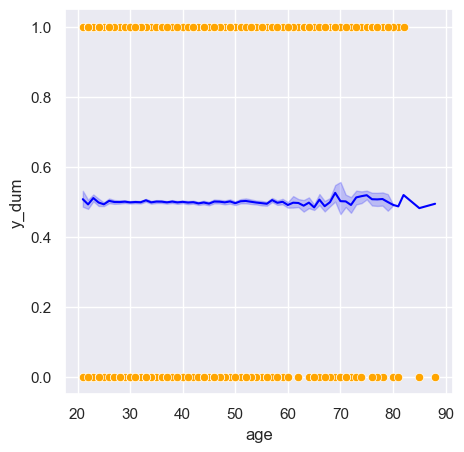

In [229]:
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(x = 'age', y = 'y_dum', data = train, color = 'orange') #Visualizing data
sns.lineplot(x = 'age', y= model1.predict(data), data = train, color = 'blue') #Visualizing model

Classification accuracy = 50.0%
Precision = 50.0%
TPR or Recall = 100.0%
FNR = 0.0%
FPR = 100.0%
ROC-AUC = 52.1%


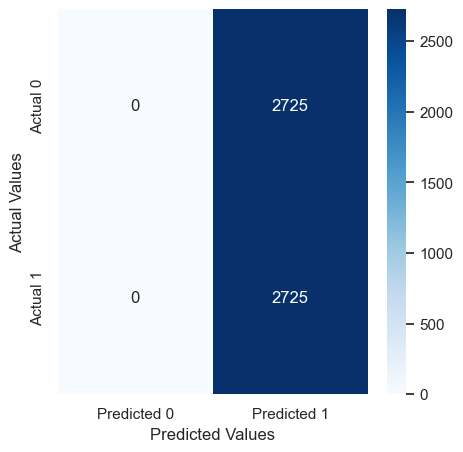

In [230]:
confusion_matrix_data(train,train.y_dum,model1,0.3)

Optimization terminated successfully.
         Current function value: 0.690819
         Iterations 5


-3764.9642325618324

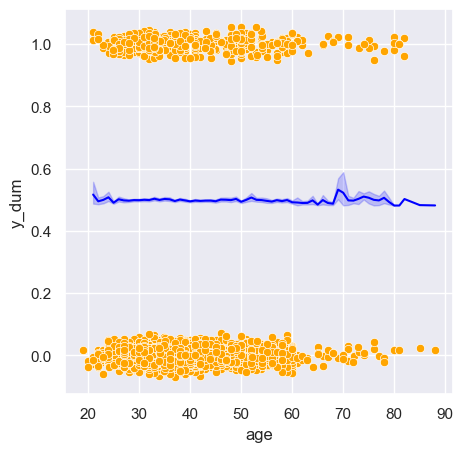

In [231]:
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(data.age,0), y = jitter(data.y_dum,0), data = train, color = 'orange')
model1_quadra = smf.logit(formula = 'y_dum~age+I(age**2)', data = train).fit()
sns.lineplot(x = 'age', y= model1_quadra.predict(data), data = train, color = 'blue') 
model1_quadra.llf

Classification accuracy = 50.0%
Precision = 50.0%
TPR or Recall = 100.0%
FNR = 0.0%
FPR = 100.0%
ROC-AUC = 50.0%


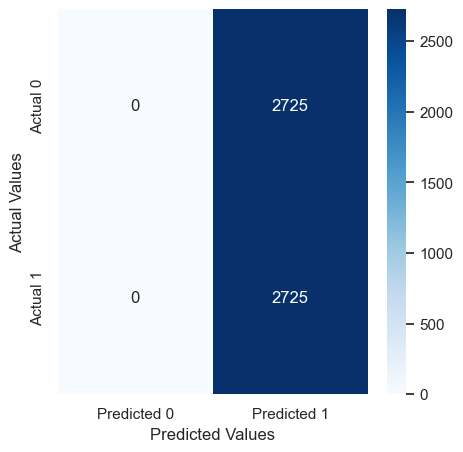

In [232]:
confusion_matrix_data(train,train.y_dum,model1_quadra,0.3)

In [233]:
#try interacting education, housing, and loan
model2 = sm.logit(formula = 'y_dum~age+job+marital+housing*loan+contact+month+day_of_week+campaign+pdays+previous+poutcome+euribor3m+emp_var_rate+cons_price_idx+cons_conf_idx+nr_employed', data = train).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.476819
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5419
Method:                           MLE   Df Model:                           30
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3121
Time:                        13:46:38   Log-Likelihood:                -2598.7
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -122.6727     34.474     -3.558      0.000    -190.240     -55.106
job[T.Unemployed]             -1.0431      0.137     -7.619      0.000      -1.311      -0.775
marital[T.single]             -0.1052      0.074     -1.426      0.154      -0.250       0.039
housing[T.yes]                 0.1947      0.074      2.645      0.008       0.050       0.339
loan[T.yes]                   -1.5693      0.223     -7.025      0.000      -2.007      -1.131
contact[T.telephone]          -1.3880      0.133    -10.455      0.000      -1.648      -1.128
month[T.aug]                   0.4661      0.203      2.293      0.022       0.068       0.865
month[T.dec]                   1.0869      0.568      1.914      0.056      -0.026       2.200
month[T.jul]                   0.2988      0.193      1.544      0.123      -0.080       0.678
month[T.jun]                   0.5790      0.192      3.017      0.003       0.203       0.955
month[T.mar]                   0.8725      0.369      2.364      0.018       0.149       1.596
month[T.may]                   0.0613      0.159      0.387      0.699      -0.250       0.372
month[T.nov]                  -0.7042      0.206     -3.427      0.001      -1.107      -0.301
month[T.oct]                   1.0515      0.291      3.614      0.000       0.481       1.622
month[T.sep]                  -0.7303      0.327     -2.231      0.026      -1.372      -0.089
day_of_week[T.mon]             0.1103      0.106      1.036      0.300      -0.098       0.319
day_of_week[T.thu]            -0.1819      0.109     -1.663      0.096      -0.396       0.032
day_of_week[T.tue]            -0.0711      0.113     -0.630      0.528      -0.292       0.150
day_of_week[T.wed]            -0.1768      0.117     -1.516      0.130      -0.405       0.052
poutcome[T.nonexistent]        1.3668      0.183      7.470      0.000       1.008       1.725
poutcome[T.success]            4.2655      0.675      6.319      0.000       2.943       5.588
housing[T.yes]:loan[T.yes]    -0.0881      0.282     -0.312      0.755      -0.641       0.464
age                            0.0081      0.004      2.227      0.026       0.001       0.015
campaign                      -0.2858      0.027    -10.774      0.000      -0.338      -0.234
pdays                          0.0009      0.001      1.270      0.204      -0.000       0.002
previous                      -0.3547      0.126     -2.808      0.005      -0.602      -0.107
euribor3m                      0.6878      0.209      3.296      0.001       0.279       1.097
emp_var_rate                  -1.2750      0.164     -7.772      0.000      -1.597      -0.953
cons_price_idx                 1.6084      0.218      7.380      0.000       1.181       2.036
cons_conf_idx                  0.0377      0.014      2.658      0.008       0.010       0.066
nr_employed                   -0.0059      0.003     -1.759      0.079      -0.012       0.001
===========

Classification accuracy = 69.5%
Precision = 64.2%
TPR or Recall = 88.2%
FNR = 11.8%
FPR = 49.1%
ROC-AUC = 84.8%


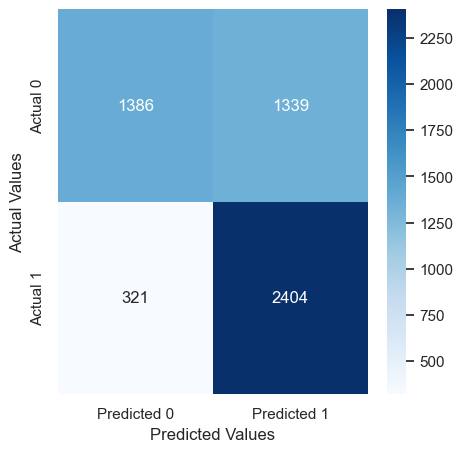

In [234]:
confusion_matrix_data(train,train.y_dum,model2,0.3)

In [235]:
#try interacting education, housing, and loan; adding campaign and poutcome
model3 = sm.logit(formula = 'y_dum~age+job+marital+education*housing*loan+contact+month+day_of_week+np.log(campaign)+campaign*poutcome+pdays+previous+I(previous**2)+euribor3m+cons_conf_idx+I(cons_conf_idx**2)+I(cons_conf_idx**3)', data = train).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.480476
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5408
Method:                           MLE   Df Model:                           41
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3068
Time:                        13:46:56   Log-Likelihood:                -2618.6
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                           -66.1033     11.846     -5.580      0.000     -89.320     -42.886
job[T.Unemployed]                                    -0.8937      0.134     -6.661      0.000      -1.157      -0.631
marital[T.single]                                    -0.1069      0.074     -1.442      0.149      -0.252       0.038
education[T.Secondary]                                0.3144      0.140      2.253      0.024       0.041       0.588
education[T.Tertiary]                                 0.3595      0.148      2.432      0.015       0.070       0.649
housing[T.yes]                                        0.1930      0.142      1.362      0.173      -0.085       0.471
loan[T.yes]                                          -1.0967      0.348     -3.149      0.002      -1.779      -0.414
contact[T.telephone]                                 -0.6745      0.115     -5.864      0.000      -0.900      -0.449
month[T.aug]                                          0.1578      0.196      0.804      0.422      -0.227       0.543
month[T.dec]                                          1.5433      0.542      2.846      0.004       0.481       2.606
month[T.jul]                                          0.5829      0.196      2.971      0.003       0.198       0.967
month[T.jun]                                          0.8108      0.189      4.289      0.000       0.440       1.181
month[T.mar]                                          0.6248      0.376      1.663      0.096      -0.112       1.361
month[T.may]                                         -0.1545      0.162     -0.955      0.339      -0.471       0.162
month[T.nov]                                         -0.2391      0.195     -1.227      0.220      -0.621       0.143
month[T.oct]                                          2.6611      0.315      8.456      0.000       2.044       3.278
month[T.sep]                                          0.0115      0.305      0.038      0.970      -0.586       0.609
day_of_week[T.mon]                                    0.1764      0.106      1.666      0.096      -0.031       0.384
day_of_week[T.thu]                                   -0.2023      0.110     -1.838      0.066      -0.418       0.013
day_of_week[T.tue]                                   -0.0114      0.113     -0.101      0.920      -0.233       0.210
day_of_week[T.wed]                                   -0.1403      0.117     -1.200      0.230      -0.370       0.089
poutcome[T.nonexistent]                               0.9892      0.305      3.247      0.001       0.392       1.586
poutcome[T.success]                                   5.0719      0.828      6.126      0.000       3.449       6.695
education[T.Secondary]:housing[T.yes]                 0.1365      0.181      0.755      0.450      -0.218       0.491
education[T.Tertiary]:housing[T.yes]                 -0

Classification accuracy = 70.1%
Precision = 64.7%
TPR or Recall = 88.3%
FNR = 11.7%
FPR = 48.2%
ROC-AUC = 84.4%


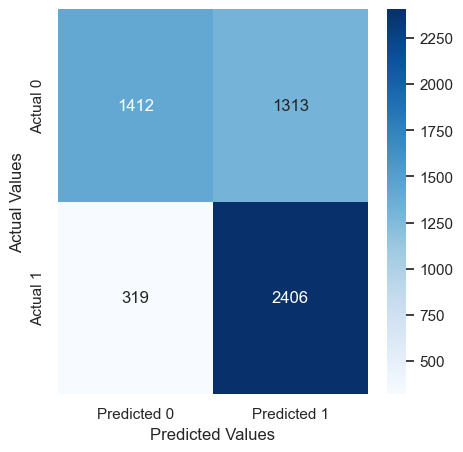

In [236]:
confusion_matrix_data(train,train.y_dum,model3,0.3)

Classification accuracy = 51.7%
Precision = 15.2%
TPR or Recall = 73.8%
FNR = 26.2%
FPR = 51.0%
ROC-AUC = 72.2%


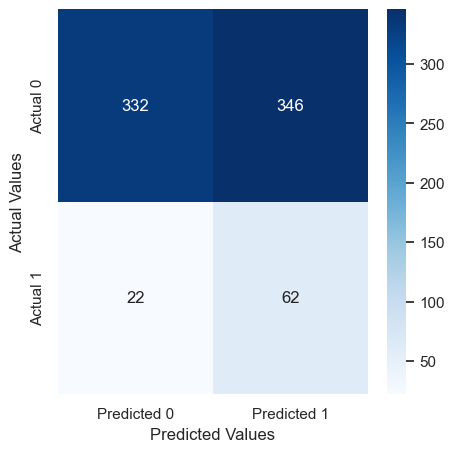

In [237]:
confusion_matrix_data(test,test.y_dum,model3,0.3)

In [238]:
#try interacting education, housing, and loan; adding pdays and poutcome
model4 = sm.logit(formula = 'y_dum~age+job+marital+education*housing*loan+contact+month+day_of_week+campaign+poutcome*pdays+previous+euribor3m+emp_var_rate+cons_price_idx+cons_conf_idx+nr_employed', data = train_smote).fit()
model4.summary()

         Current function value: inf
         Iterations: 35


/Users/cuiyide/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/cuiyide/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/cuiyide/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cuiyide/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5409
Method:                           MLE   Df Model:                           40
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                    -inf
Time:                        13:47:22   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          -122.2310     34.690     -3.524      0.000    -190.222     -54.240
job[T.Unemployed]                                    -1.0390      0.138     -7.541      0.000      -1.309      -0.769
marital[T.single]                                    -0.1597      0.075     -2.129      0.033      -0.307      -0.013
education[T.Secondary]                                0.2396      0.140      1.714      0.087      -0.034       0.514
education[T.Tertiary]                                 0.3128      0.147      2.123      0.034       0.024       0.602
housing[T.yes]                                        0.1600      0.143      1.122      0.262      -0.119       0.439
loan[T.yes]                                          -1.3413      0.359     -3.736      0.000      -2.045      -0.638
contact[T.telephone]                                 -1.3692      0.134    -10.213      0.000      -1.632      -1.106
month[T.aug]                                          0.4353      0.205      2.125      0.034       0.034       0.837
month[T.dec]                                          1.1131      0.579      1.922      0.055      -0.022       2.248
month[T.jul]                                          0.3000      0.195      1.538      0.124      -0.082       0.682
month[T.jun]                                          0.5734      0.194      2.955      0.003       0.193       0.954
month[T.mar]                                          0.8006      0.369      2.169      0.030       0.077       1.524
month[T.may]                                          0.0493      0.160      0.308      0.758      -0.265       0.363
month[T.nov]                                         -0.7651      0.208     -3.684      0.000      -1.172      -0.358
month[T.oct]                                          0.9712      0.293      3.313      0.001       0.397       1.546
month[T.sep]                                         -0.7267      0.330     -2.204      0.028      -1.373      -0.080
day_of_week[T.mon]                                    0.1024      0.107      0.956      0.339      -0.108       0.312
day_of_week[T.thu]                                   -0.1976      0.110     -1.792      0.073      -0.414       0.018
day_of_week[T.tue]                                   -0.0703      0.113     -0.620      0.535      -0.292       0.152
day_of_week[T.wed]                                   -0.1511      0.118     -1.283      0.200      -0.382       0.080
poutcome[T.nonexistent]                           -3.718e+06        nan        nan        nan         nan         nan
poutcome[T.success]                                   3.6927      0.733      5.040      0.000       2.257       5.129
education[T.Secondary]:housing[T.yes]                 0.1719      0.182      0.944      0.345      -0.185       0.529
education[T.Tertiary]:housing[T.yes]                 -0

Classification accuracy = 70.3%
Precision = 64.8%
TPR or Recall = 88.8%
FNR = 11.2%
FPR = 48.3%
ROC-AUC = 85.1%


/Users/cuiyide/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


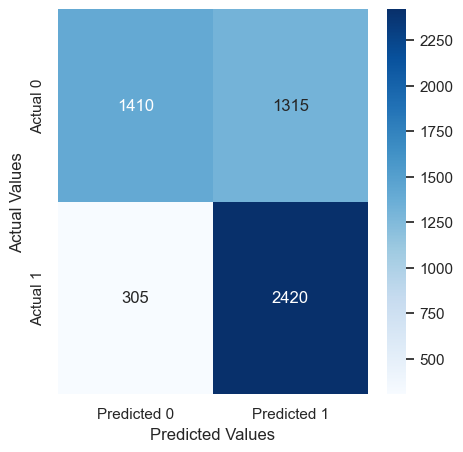

In [239]:
confusion_matrix_data(train_smote,train_smote.y_dum,model4,0.3)

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [196]:
logit_model = sm.logit(formula = 'y_dum~age+job*loan+marital+education+month+day_of_week+np.log(campaign)+previous+I(previous**2)+poutcome_modified*loan+euribor3m+cons_conf_idx+I(cons_conf_idx**2)+I(cons_conf_idx**3)', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.493937
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5420
Method:                           MLE   Df Model:                           29
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.2874
Time:                        13:37:07   Log-Likelihood:                -2692.0
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  -56.7370     11.600     -4.891      0.000     -79.472     -34.002
job[T.Unemployed]                           -1.0428      0.139     -7.521      0.000      -1.315      -0.771
loan[T.yes]                                 -1.5820      0.142    -11.157      0.000      -1.860      -1.304
marital[T.single]                           -0.1363      0.073     -1.869      0.062      -0.279       0.007
education[T.Secondary]                       0.4160      0.086      4.825      0.000       0.247       0.585
education[T.Tertiary]                        0.2535      0.092      2.763      0.006       0.074       0.433
month[T.aug]                                 0.4753      0.181      2.620      0.009       0.120       0.831
month[T.dec]                                 1.1946      0.515      2.319      0.020       0.185       2.204
month[T.jul]                                 0.8700      0.184      4.717      0.000       0.508       1.231
month[T.jun]                                 0.6592      0.182      3.631      0.000       0.303       1.015
month[T.mar]                                 0.7045      0.376      1.875      0.061      -0.032       1.441
month[T.may]                                -0.2653      0.157     -1.691      0.091      -0.573       0.042
month[T.nov]                                -0.0618      0.188     -0.328      0.743      -0.431       0.307
month[T.oct]                                 2.5670      0.309      8.314      0.000       1.962       3.172
month[T.sep]                                -0.0242      0.297     -0.082      0.935      -0.606       0.558
day_of_week[T.mon]                           0.2272      0.104      2.189      0.029       0.024       0.431
day_of_week[T.thu]                          -0.1936      0.108     -1.791      0.073      -0.405       0.018
day_of_week[T.tue]                          -0.0333      0.111     -0.300      0.764      -0.251       0.184
day_of_week[T.wed]                          -0.1758      0.115     -1.527      0.127      -0.402       0.050
poutcome_modified[T.success]                 3.3747      0.238     14.168      0.000       2.908       3.842
job[T.Unemployed]:loan[T.yes]                0.8461      0.444      1.904      0.057      -0.025       1.717
poutcome_modified[T.success]:loan[T.yes]    -0.9857      0.618     -1.595      0.111      -2.197       0.225
age                                          0.0079      0.004      2.241      0.025       0.001       0.015
np.log(campaign)                            -0.6472      0.059    -11.049      0.000      -0.762      -0.532
previous                                    -1.9463      0.191    -10.188      0.000      -2.321      -1.572
I(previous ** 2)                             0.4488      0.075      5.963      0.000       0.301       0.596
euribor3m                                   -0.6512      0.031    -21.189      0

Classification accuracy = 74.5%
Precision = 75.0%
TPR or Recall = 73.5%
FNR = 26.5%
FPR = 24.4%
ROC-AUC = 83.2%


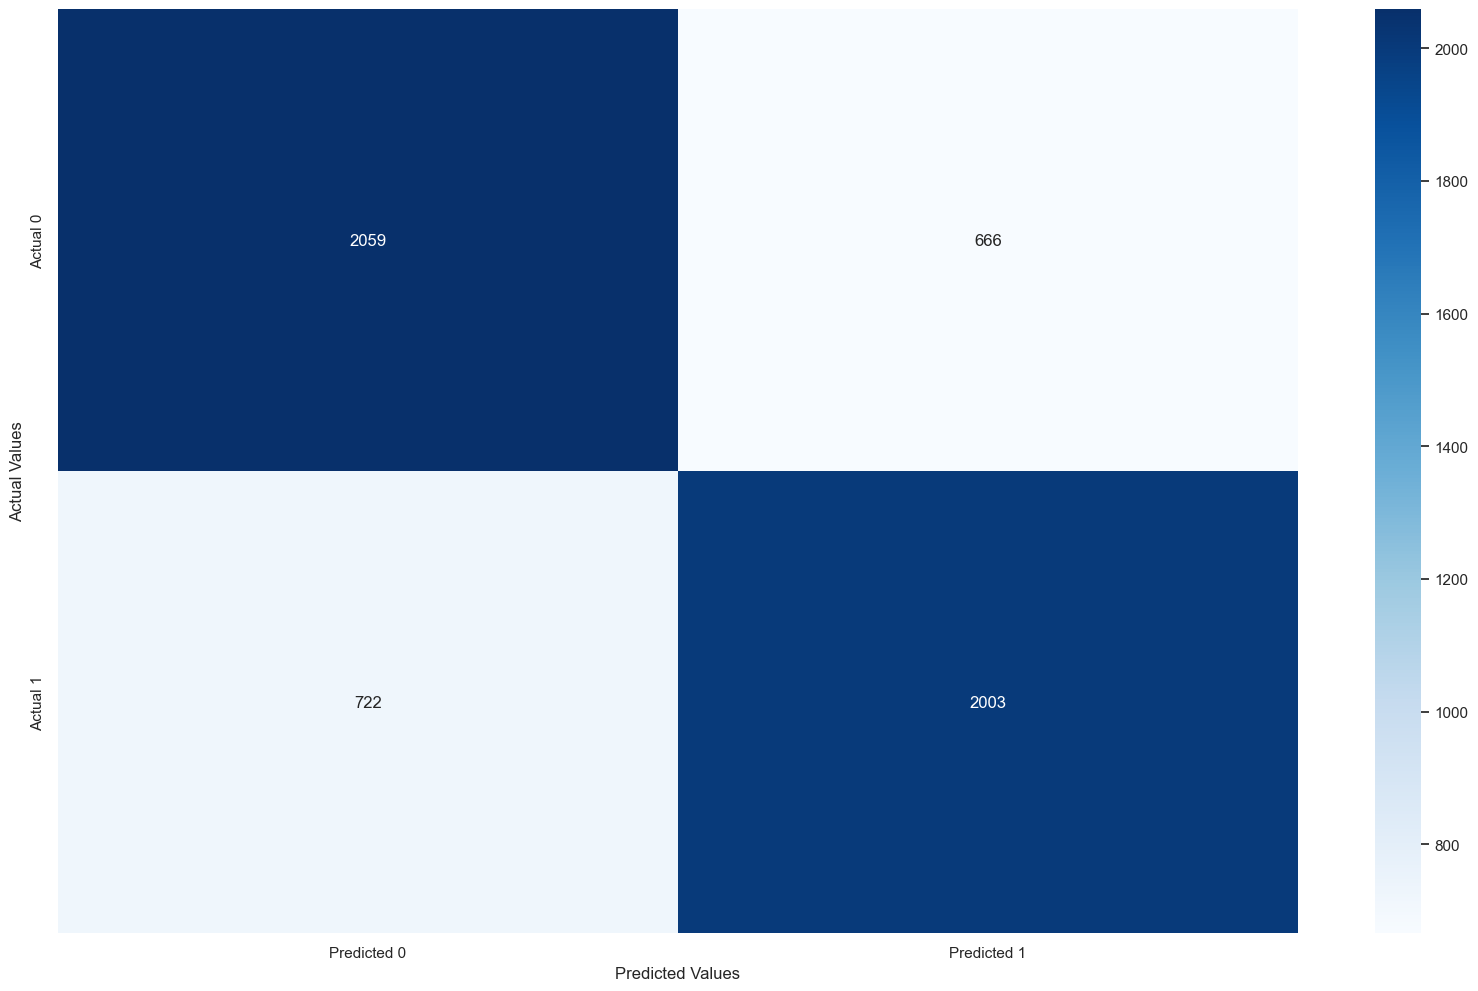

In [217]:
confusion_matrix_data(train,train.y_dum,logit_model,0.45)

Classification accuracy = 72.4%
Precision = 22.8%
TPR or Recall = 63.1%
FNR = 36.9%
FPR = 26.4%
ROC-AUC = 73.4%


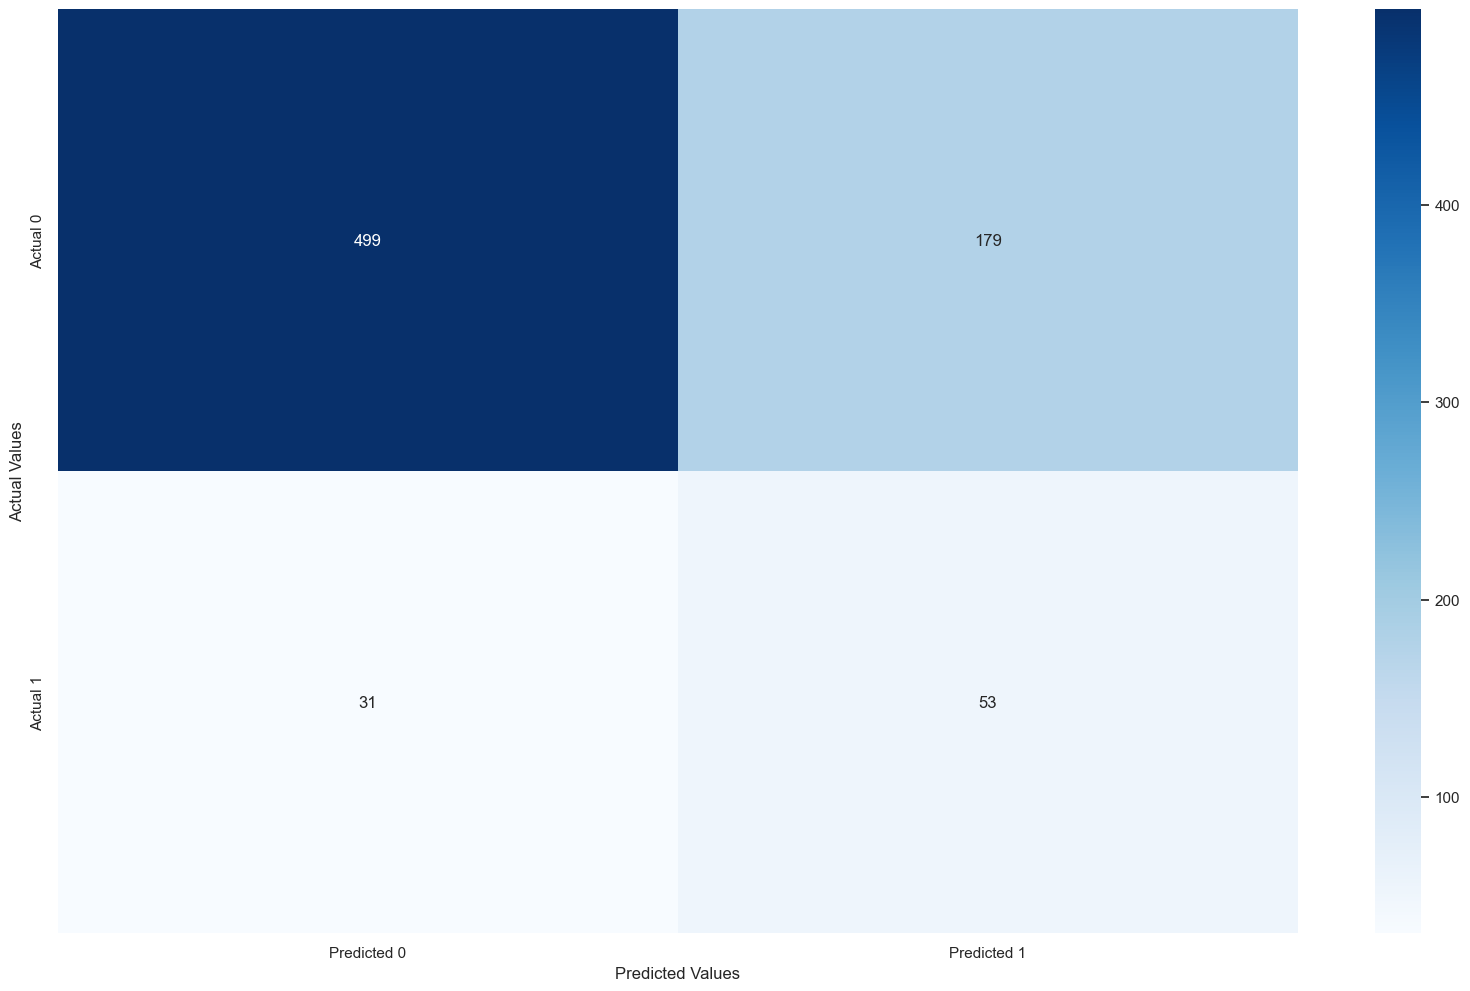

In [218]:
confusion_matrix_data(test,test.y_dum,logit_model,0.45)

## Conclusions and Recommendations to stakeholder(s)